In [33]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy import signal
import cmath, math

In [34]:
plt.rcParams["figure.figsize"] = (15, 5)

In [35]:
def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi для преобразования в радианы
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Генерируем волну с частотой 2 Гц, которая длится 5 секунд
# x, y = generate_sine_wave(2, 1000, 1)
# plt.plot(x, y)
# plt.show()

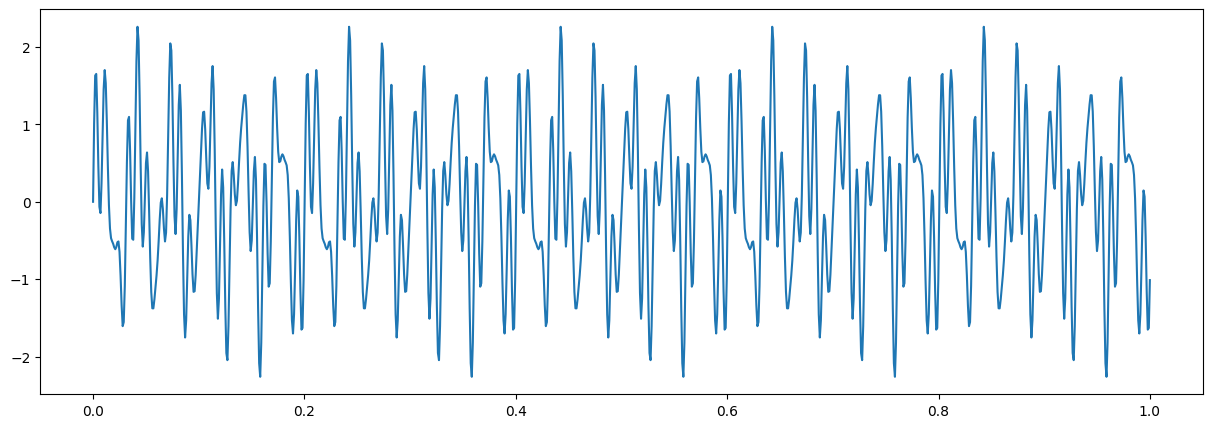

In [36]:
SAMPLE_RATE = 1000
DURATION = 1
N = SAMPLE_RATE * DURATION

_, nice_tone0 = generate_sine_wave(20, SAMPLE_RATE, DURATION)
_, noise_tone1 = generate_sine_wave(80, SAMPLE_RATE, DURATION)
_, noise_tone2 = generate_sine_wave(60, SAMPLE_RATE, DURATION)
_, nice_tone3 = generate_sine_wave(30, SAMPLE_RATE, DURATION)
_, noise_tone4 = generate_sine_wave(100, SAMPLE_RATE, DURATION)
_, noise_tone5 = generate_sine_wave(125, SAMPLE_RATE, DURATION)

mixed_tone1 = 1 * nice_tone0 + 0.1 * noise_tone1 + 0.3 * noise_tone2

mixed_tone2 = 1 * nice_tone3 + 0.8 * noise_tone4 + 0.5 * noise_tone5

# plt.subplot(1, 2, 1)
# plt.plot(np.linspace(0, DURATION, N), mixed_tone1)
#
# plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, DURATION, N), mixed_tone2)

plt.show()

In [37]:
def transformFrequency(w):
    return np.tan(np.pi * w / SAMPLE_RATE)

In [38]:
def AFH_H(w, cutoff, n=2):
    return 1 / np.sqrt(1 + (w / cutoff) ** (2 * n))

# cutoff задает частоту среза фильтра Баттерворта

In [39]:
n = 8
cutoff = 75

In [40]:
def C(k, n):
    return math.factorial(n) / (math.factorial(n - k) * math.factorial(k))

In [41]:
def getCoeffs(order, w):

    def commonCode(n):

        p = None
        if n % 2 == 0:
            p = n
        else:
            p = (n - 1)

        numerator = ((- w * w) ** (p / 2)) * np.array([C(k, p) for k in range(p + 1)])
        denominator = np.zeros(p + 1)

        def denCoeffs(degree=0, prod=1, k=1):
            def a(k):
                return 2 * w * math.cos(math.pi * k / n) * math.sin(math.pi / (2 * n)) - 2 * w * math.sin(
                    math.pi * k / n) * math.cos(math.pi / (2 * n)) - w * w - 1

            def b(k):
                return -2 * w * w + 2

            def c(k):
                return -2 * w * math.cos(math.pi * k / n) * math.sin(math.pi / (2 * n)) + 2 * w * math.sin(
                    math.pi * k / n) * math.cos(math.pi / (2 * n)) - w * w - 1

            if k > p / 2:
                denominator[degree] += prod
                return

            if degree + 2 <= p:
                denCoeffs(degree + 2, prod * a(k), k + 1)

            if degree + 1 <= p:
                denCoeffs(degree + 1, prod * b(k), k + 1)

            if degree <= p:
                denCoeffs(degree, prod * c(k), k + 1)

        denCoeffs()

        return numerator, denominator


    if order % 2 == 0:
        # when even order, then order = n else order = n - 1
        numerator, denominator = commonCode(order)
        a0 = denominator[-1]
        return numerator / a0, denominator[:-1] / a0
    else:
        numerator, denominator = [np.append(i, 0) for i in commonCode(order)]
        zNumerator = np.roll(numerator, 1)
        zDenominator = np.roll(denominator, 1)

        numerator = (zNumerator + numerator) * w
        denominator = (zDenominator + denominator) * w + (zDenominator - denominator)

        a0 = denominator[-1]
        return numerator / a0, denominator[:-1] / a0

# getCoeffs(3, w)

In [42]:
def processingOfSignal(input, cutoff, n=2):

    w = transformFrequency(cutoff)

    numerator, denominator = getCoeffs(n, w)

    numberOfX = numerator.size
    numberOfY = denominator.size

    output = np.zeros_like(input)
    # output = input.copy()

    for i in range(output.size - numberOfX + 1):
        output[numberOfX - 1 + i] = (input[i:numberOfX + i] * numerator).sum() - (
                    output[(numberOfX - 1 + i) - numberOfY:numberOfX - 1 + i] * denominator).sum()

    return output

# output = processingOfSignal(mixed_tone, cutoff, 20)

In [43]:
yf = rfft(mixed_tone2)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

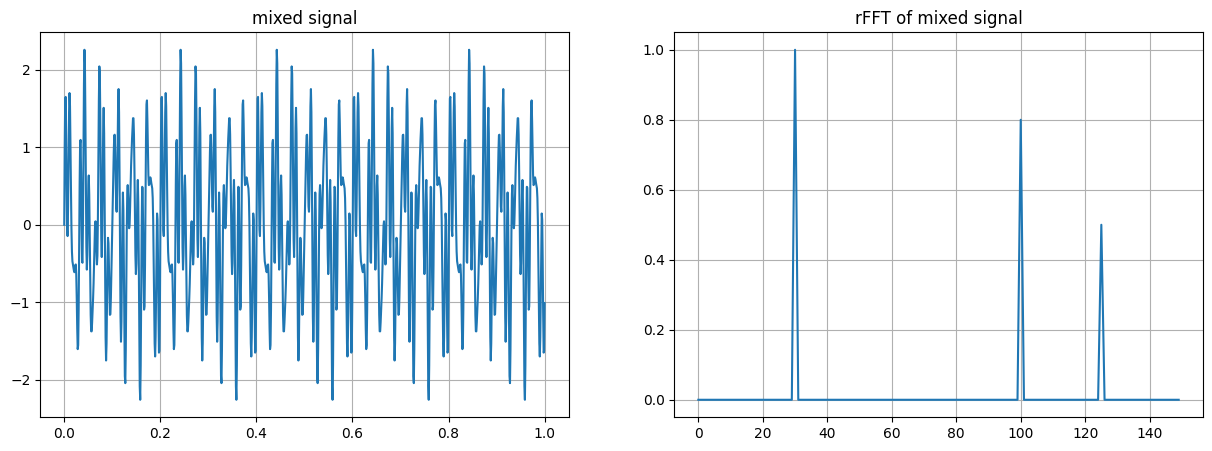

In [44]:
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, DURATION, N), mixed_tone2)
plt.grid()
plt.title("mixed signal")

bound = 150
plt.subplot(1, 2, 2)
plt.plot(xf[:bound], np.abs(yf[:bound]) / 500)
plt.grid()
plt.title("rFFT of mixed signal")

plt.show()

In [45]:
output = processingOfSignal(mixed_tone2, cutoff, n)
yf = rfft(output)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

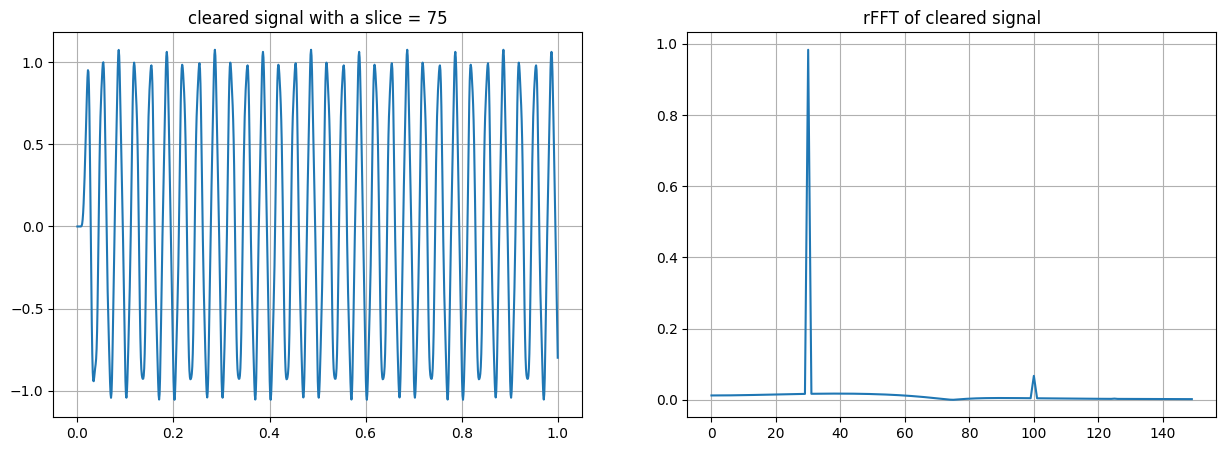

In [46]:
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, DURATION, N), output)
plt.grid()
plt.title(f"cleared signal with a slice = {cutoff}")

bound = 150
plt.subplot(1, 2, 2)
plt.plot(xf[:bound], np.abs(yf[:bound]) / 500)
plt.grid()
plt.title("rFFT of cleared signal")

plt.show()

# Аналитический АЧХ аналоговой функции Баттерворта

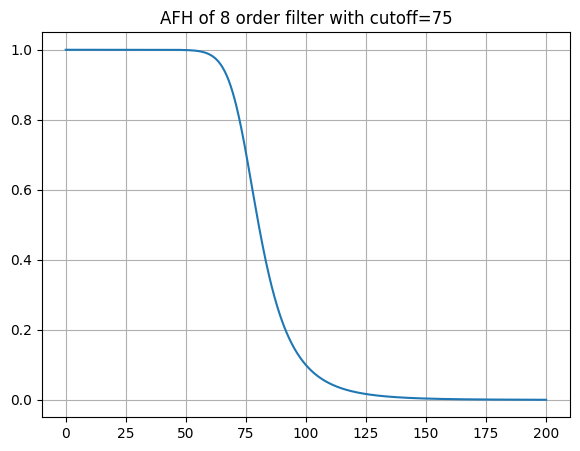

In [47]:
f = np.linspace(0, 200, 1000)

plt.subplot(1, 2, 1)
plt.plot(f, AFH_H(f, cutoff, n))
plt.grid()
plt.title(f"AFH of {n} order filter with cutoff={cutoff}")

# plt.subplot(1, 2, 2)
# H_jw = 1 / (-f ** 2 + np.sqrt(2) * f * 1j + 1)
# plt.plot(f, [cmath.phase(i) for i in H_jw])
# plt.grid()
# plt.title("APH of filter")

plt.show()

# Фактический АЧХ фильтра

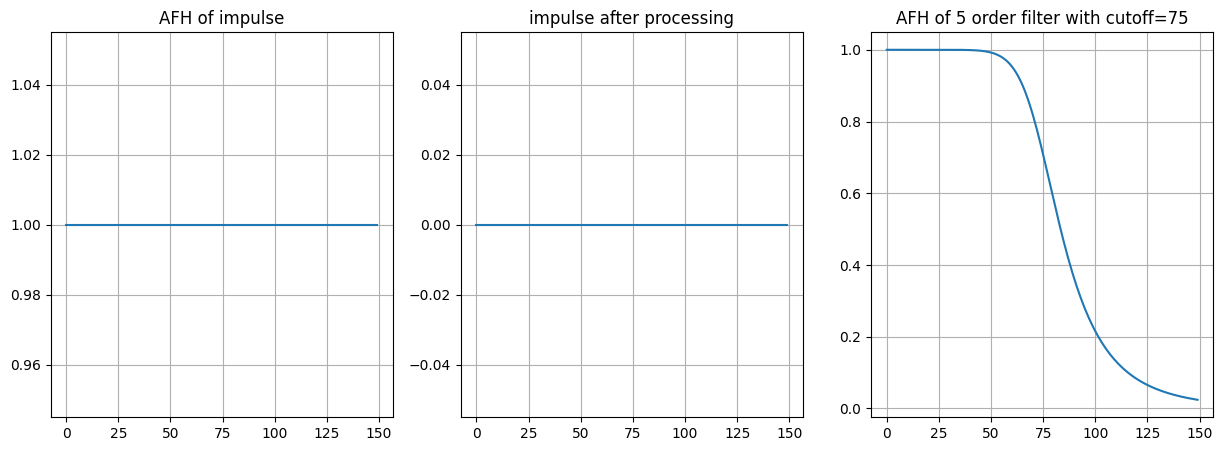

In [48]:
n = 5

test = np.zeros(1000)
test[500] = 1

N = SAMPLE_RATE

yf = rfft(test)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

bound = 150
plt.subplot(1, 3, 1)
plt.plot(xf[:bound], np.abs(yf[:bound]))
plt.grid()
plt.title("AFH of impulse")

output = processingOfSignal(test, cutoff, n)

bound = 150
plt.subplot(1, 3, 2)
plt.plot(output[:bound])
plt.grid()
plt.title("impulse after processing")

yf = rfft(output)

bound = 150
plt.subplot(1, 3, 3)
plt.plot(xf[:bound], np.abs(yf[:bound]))
plt.grid()
plt.title(f"AFH of {n} order filter with cutoff={cutoff}")

plt.show()